# 02 - Data from the Web

## Deadline
Wednesday October 25, 2017 at 11:59PM

## Important Notes
* Make sure you push on GitHub your Notebook with all the cells already evaluated (i.e., you don't want your colleagues to generate unnecessary Web traffic during the peer review)
* Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you plan to implement!
* Please write all your comments in English, and use meaningful variable names in your code.

## Background
In this homework we will extract interesting information from www.topuniversities.com and www.timeshighereducation.com, two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need!
You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. For this task, Postman with the Interceptor extension can help you greatly. We recommend that you watch this [brief tutorial](https://www.youtube.com/watch?v=jBjXVrS8nXs&list=PLM-7VG-sgbtD8qBnGeQM5nvlpqB_ktaLZ&autoplay=1) to understand quickly how to use it.

## Assignment
1. Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).
Store the resulting dataset in a pandas DataFrame and answer the following questions:
- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- Answer the previous question aggregating the data by (c) country and (d) region.

Plot your data using bar charts and describe briefly what you observed.

2. Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

3. Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

4. Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

5. Can you find the best university taking in consideration both rankings? Explain your approach.

Hints:
- Keep your Notebook clean and don't print the verbose output of the requests if this does not add useful information for the reader.
- In case of tie, use the order defined in the webpage.

In [1]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Make a request
url_main = 'https://www.topuniversities.com'  # Found with postman
r = requests.get(url_main + '/sites/default/files/qs-rankings-data/357051.txt')
print('Response status code: {0}\n'.format(r.status_code))

page_body = r.text

# Serialize the json data with json library
rank_json = json.loads(page_body)

Response status code: 200



In [3]:
rank_df = pd.DataFrame()
rank_df = rank_df.from_dict(rank_json['data']).head(200)
rank_df.stars
rank_df.drop(['logo', 'stars', 'nid','cc', 'score'], axis=1, inplace=True)
rank_df.set_index('core_id', inplace=True)
rank_df = rank_df[['title', 'rank_display', 'country', 'region', 'url']]
rank_df.head(5)

,title,rank_display,country,region,url
core_id,,,,,
410,Massachusetts Institute of Technology (MIT),1,United States,North America,/universities/massachusetts-institute-technolo...
573,Stanford University,2,United States,North America,/universities/stanford-university
253,Harvard University,3,United States,North America,/universities/harvard-university
94,California Institute of Technology (Caltech),4,United States,North America,/universities/california-institute-technology-...
95,University of Cambridge,5,United Kingdom,Europe,/universities/university-cambridge


In [4]:
# Find the values for number of faculty members and students
fac_memb_tot = []
fac_memb_int = []
nb_stud_tot = []
nb_stud_int = []

for url in rank_df.url:
    
    uni_url = requests.get(url_main + url)
    uni_body = uni_url.text
    
    # 1) Faculty Members: 
    # 1.1) Total
    soup = BeautifulSoup(uni_body, 'html.parser')
    soup1 = soup.find('div', class_='total faculty')
    if soup1:
        soup2 = soup1.find('div', class_='number')
        if soup2:
            fac_memb_tot.append({'fac_memb_tot': soup2.text})
        else:
            fac_memb_tot.append({'fac_memb_tot': -99})
    else:
        fac_memb_tot.append({'fac_memb_tot': -99})
        
    # 1.2) International
    soup3 = soup.find('div', class_='inter faculty')
    if soup3:
        soup4 = soup3.find('div', class_='number')
        if soup4:
            fac_memb_int.append({'fac_memb_int': soup4.text})
        else:
            fac_memb_int.append({'fac_memb_int': -99})
    else:
        fac_memb_int.append({'fac_memb_int': -99})
        
    # 2) Students:
    # 2.1) Total
    soup5 = soup.find('div', class_='total student')
    if soup5:
        soup6 = soup5.find('div', class_='number')
        if soup6:
            nb_stud_tot.append({'nb_stud_tot': soup6.text})
        else:
            nb_stud_tot.append({'nb_stud_tot': -99})
    else:
        nb_stud_tot.append({'nb_stud_tot': -99})
    
    # 2.2) International
    soup7 = soup.find('div', class_='total inter')
    if soup7:
        soup8 = soup7.find('div', class_='number')
        if soup8:
            nb_stud_int.append({'nb_stud_int': soup8.text})
        else:
            nb_stud_int.append({'nb_stud_int': -99})
    else:
        nb_stud_int.append({'nb_stud_int': -99})

In [5]:
# Convert the list to dataframe
fac_memb_tot1 = pd.DataFrame.from_dict(fac_memb_tot).replace({r'\n': ''}, regex=True).replace({r',': ''}, regex=True).apply(pd.to_numeric).astype(int)
            
fac_memb_int1 = pd.DataFrame.from_dict(fac_memb_int).replace({r'\n': ''}, regex=True).replace({r',': ''}, regex=True).apply(pd.to_numeric).astype(int)

nb_stud_tot1 = pd.DataFrame.from_dict(nb_stud_tot).replace({r'\n': ''}, regex=True).replace({r',': ''}, regex=True).apply(pd.to_numeric).astype(int)

nb_stud_int1 = pd.DataFrame.from_dict(nb_stud_int).replace({r'\n': ''}, regex=True).replace({r',': ''}, regex=True).apply(pd.to_numeric).astype(int)

In [6]:
# Concatenate the different dataframes
details_df = pd.concat([fac_memb_tot1, fac_memb_int1, nb_stud_tot1, nb_stud_int1], axis=1)
details_df.set_index(rank_df.index, inplace=True)
qs_df = pd.concat([rank_df, details_df], axis=1)
qs_df.drop(['url'], axis=1, inplace=True)

# Delete the = in rank_display
qs_df.rank_display = qs_df.rank_display.replace({r'=': ''}, regex=True).apply(pd.to_numeric).astype(int)

# Create the faculty members ratio and number of students ratio
qs_df['fac_memb_ratio'] = qs_df.fac_memb_tot / qs_df.nb_stud_tot
qs_df['int_stud_ratio'] = qs_df.nb_stud_int / qs_df.nb_stud_tot
qs_df.head(5)

,title,rank_display,country,region,fac_memb_tot,fac_memb_int,nb_stud_tot,nb_stud_int,fac_memb_ratio,int_stud_ratio
core_id,,,,,,,,,,
410,Massachusetts Institute of Technology (MIT),1,United States,North America,2982,1679,11067,3717,0.269450,0.335863
573,Stanford University,2,United States,North America,4285,2042,15878,3611,0.269870,0.227422
253,Harvard University,3,United States,North America,4350,1311,22429,5266,0.193945,0.234785
94,California Institute of Technology (Caltech),4,United States,North America,953,350,2255,647,0.422616,0.286918
95,University of Cambridge,5,United Kingdom,Europe,5490,2278,18770,6699,0.292488,0.356899


# Task 6: Exploratory analysis

In this section, we are going to try to find out some insigths on the data. By visualizing the data, creating new features and watching for correlations within the data variables, we are going to draw some conclusions.

The following data relations fill be inspectioned:
1. The relation of the region and country with the rank position</li>



## Region and country relation with rank position

The first questions taht comes to our mind are:
* Is there any relation with the region of a university and the probability of being in the ranking? 
* Which countries have more universities in the rankings?
* Is there a correlation between the country and the rank position?
* Is there any correlation between the richness of the country with the rank position?

### Helper functions

In [183]:
# Plot helper functions
def value_barplot_label(plot_name):
    # Inserts the value label on the top of each bar.

    for p in plot_name.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2., height + 1,'{:0.0f}'.format(height), ha="center")
    

In [209]:
qs_df.region.value_counts()

Europe           89
North America    53
Asia             37
Oceania          11
Latin America     7
Africa            1
Name: region, dtype: int64

To start, let's check how many universities are there in the ranking per region:

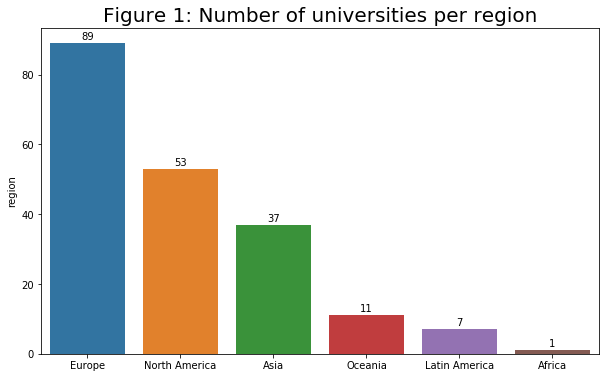

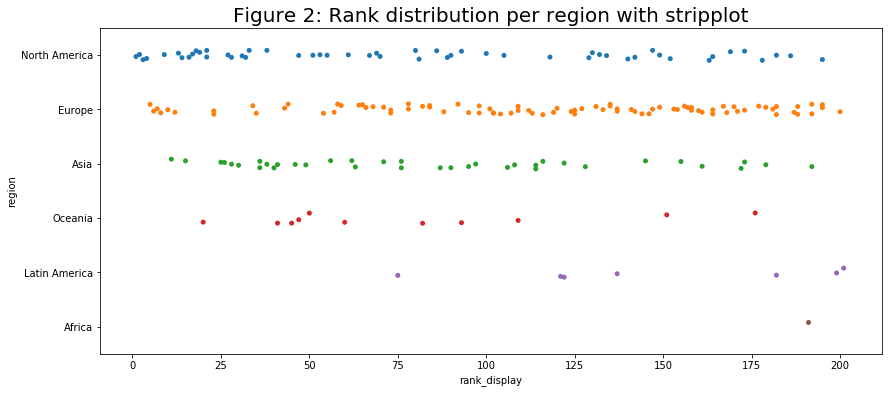

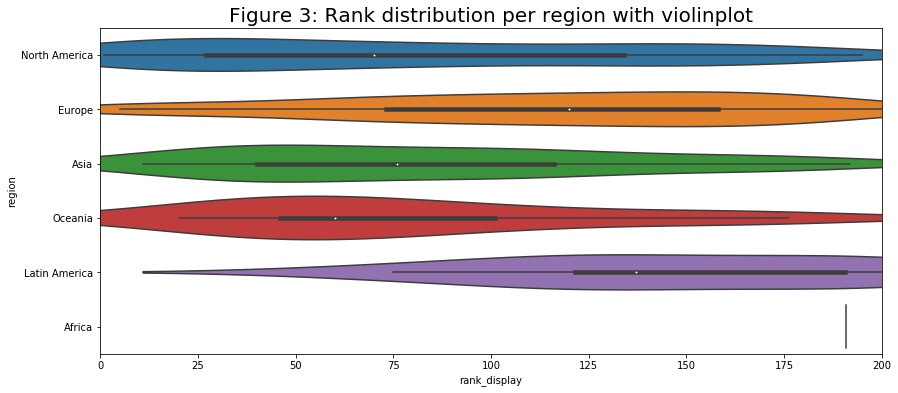

In [208]:
# Visualize how many universitie sper country are there in the best 200 ranking
plt.figure(figsize=(10,6))
regions = qs_df.region.value_counts().index
ax = sns.barplot(x=regions, y=qs_df.region.value_counts())
value_barplot_label(ax)
plt.title("Figure 1: Number of universities per region", fontsize=20)

# Rank distribution per region
plt.figure(figsize=(14,6))
sns.stripplot(x="rank_display", y="region", data=qs_df, jitter=True)
plt.title("Figure 2: Rank distribution per region with stripplot", fontsize=20)

# Rank distribution per region
plt.figure(figsize=(14,6))
sns.violinplot(x="rank_display", y="region", data=qs_df)
plt.xlim(0,200)
plt.title("Figure 3: Rank distribution per region with violinplot", fontsize=20)


From the plots above, Europe and NorthAmerica are the regions where there are the best universities (see Figure 1). In Figure 2 and 3 we can observe the distribution in the rank 

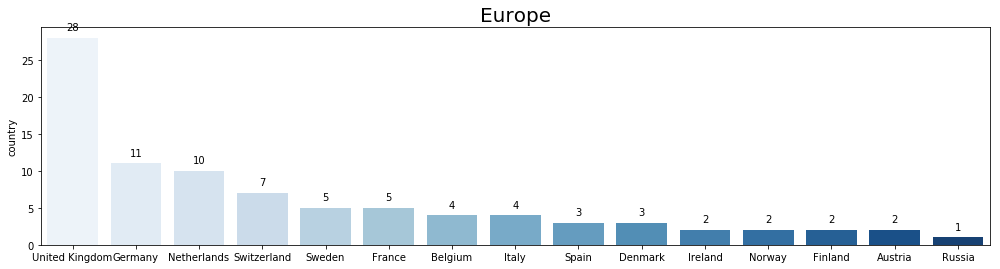

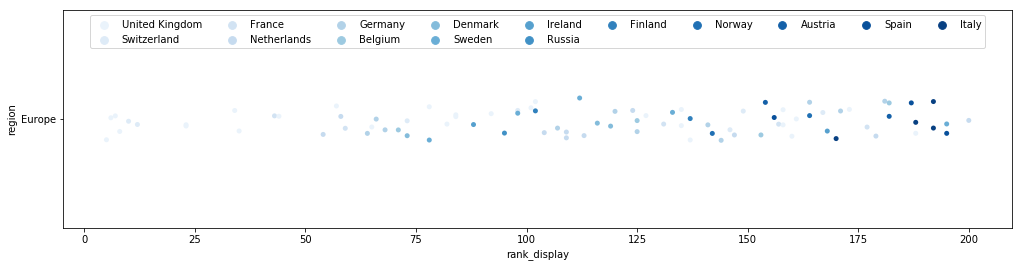

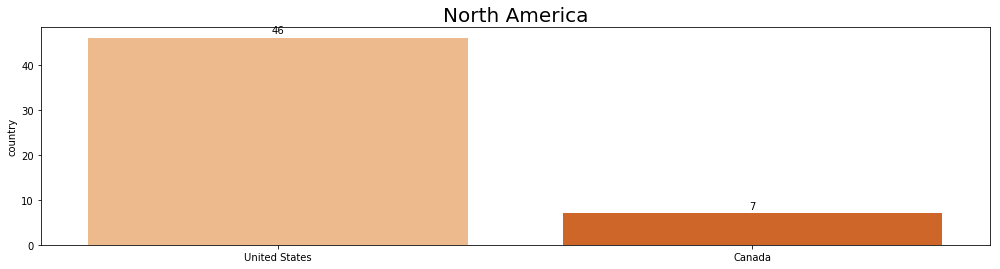

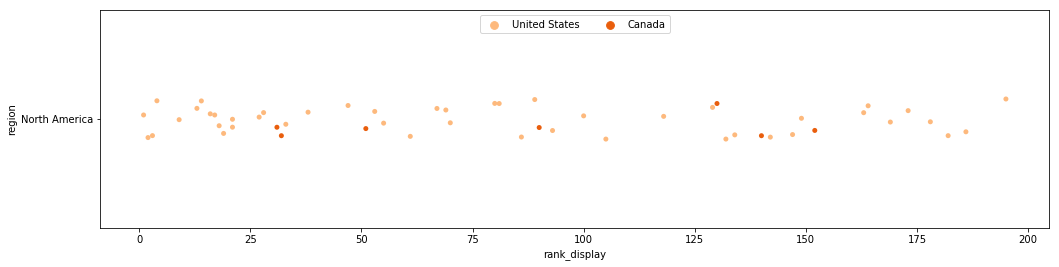

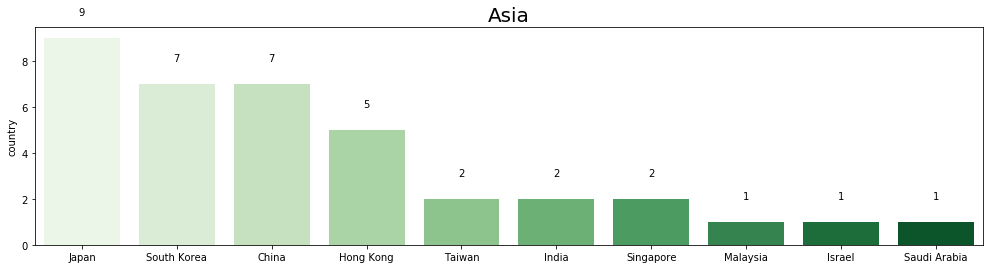

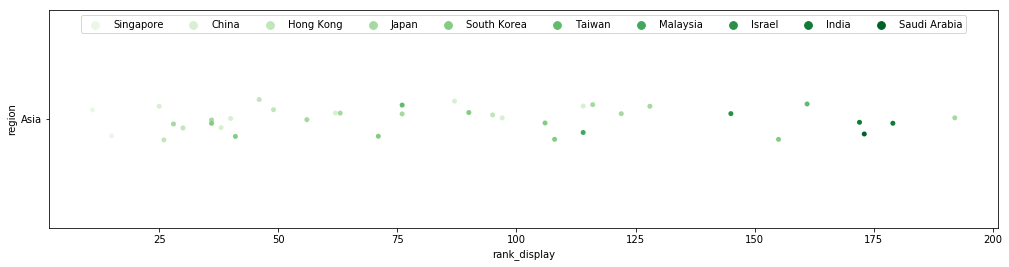

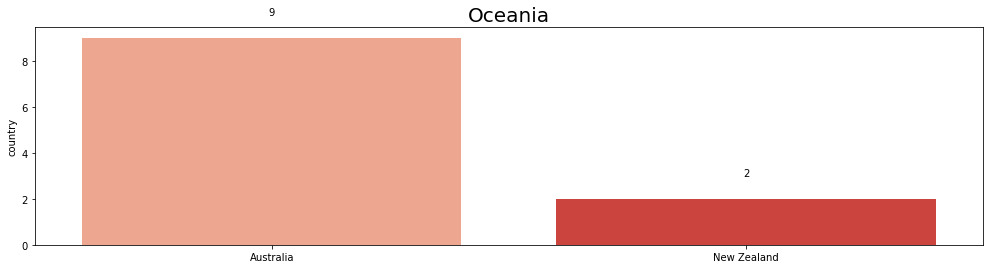

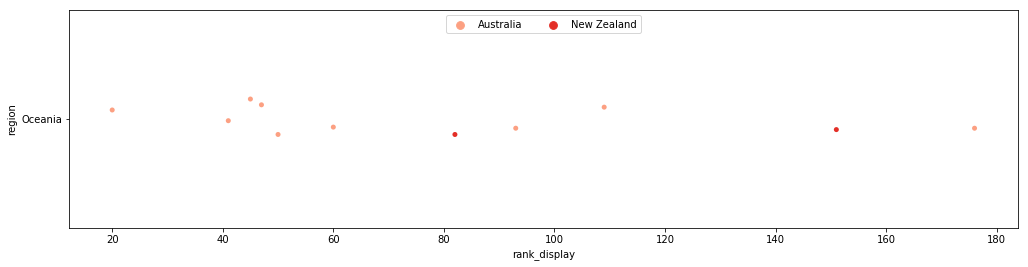

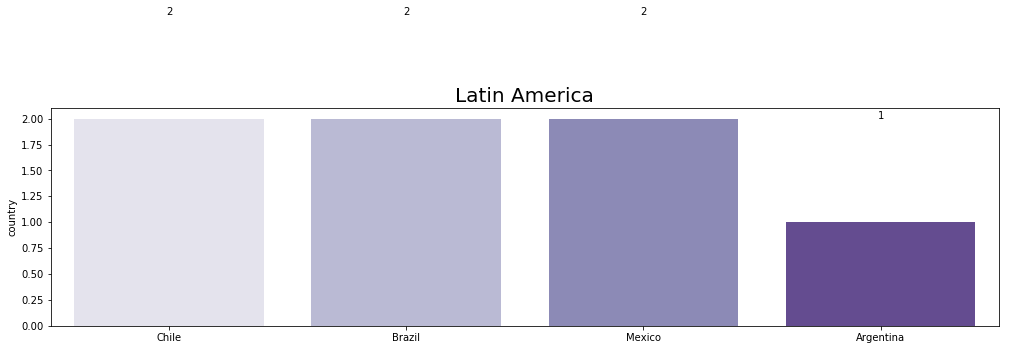

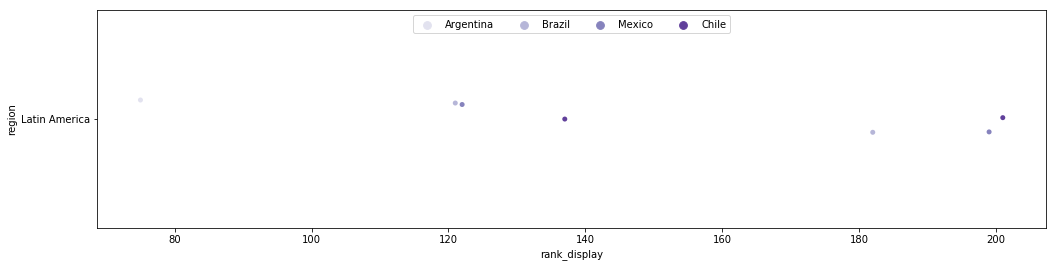

In [207]:
# Best 5 universities in Europe   
colors = ['Blues','Oranges', 'Greens', 'Reds','Purples']
for region, color in zip(regions, colors):
    plt.figure(figsize=(17,4))
    x = qs_df.country[qs_df.region==region].value_counts().index
    y = qs_df.country[qs_df.region==region].value_counts()
    ax= sns.barplot(x=x, y=y, palette=color)
    value_barplot_label(ax)
    plt.title(region, fontsize=20)
    
    plt.figure(figsize=(17,4))
    sns.stripplot(x="rank_display", y="region", data=qs_df[qs_df.region==region], jitter=True, hue="country", palette=color)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=10, fancybox=True)

In [10]:
# Drop the lines with negative values ()
qs_df = qs_df.drop(qs_df[qs_df.fac_memb_int == -99].index, axis=0)

# Describe the data
qs_df.describe()

,rank_display,fac_memb_tot,fac_memb_int,nb_stud_tot,nb_stud_int,fac_memb_ratio,int_stud_ratio,total_stud_facmemb
count,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000
mean,100.035354,2925.525253,786.409091,25818.414141,5103.671717,0.126065,0.211759,28743.939394
std,57.608461,2007.977599,666.690652,17109.328009,3918.157945,0.060589,0.116049,18686.068742
min,1.000000,86.000000,1.000000,532.000000,48.000000,0.040391,0.009892,618.000000
25%,50.250000,1674.000000,327.000000,15449.500000,2636.750000,0.084646,0.123716,17612.500000
50%,100.500000,2625.000000,599.500000,23777.500000,4280.500000,0.115368,0.194800,26592.500000
75%,149.000000,3639.750000,1027.750000,32226.500000,6883.750000,0.148596,0.280313,35779.750000
max,201.000000,16421.000000,3905.000000,141939.000000,27109.000000,0.422616,0.691393,157012.000000


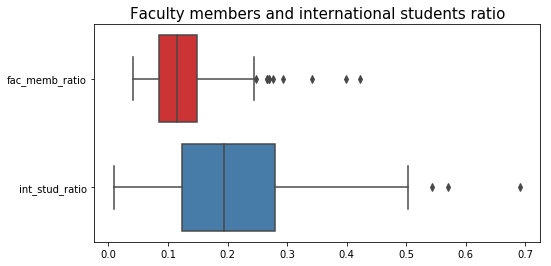

In [165]:
# Visualize the ratios with a boxplot
plt.figure(figsize=(8,4))
ax1 = sns.boxplot(data=qs_df[['fac_memb_ratio', 'int_stud_ratio']], orient="h", palette="Set1")
plt.title("Faculty members and international students ratio", fontsize=15)

In [ ]:
# Create a new feature: Total number of people in campus
qs_df['total_stud_facmemb'] = qs_df.fac_memb_tot + qs_df.nb_stud_tot

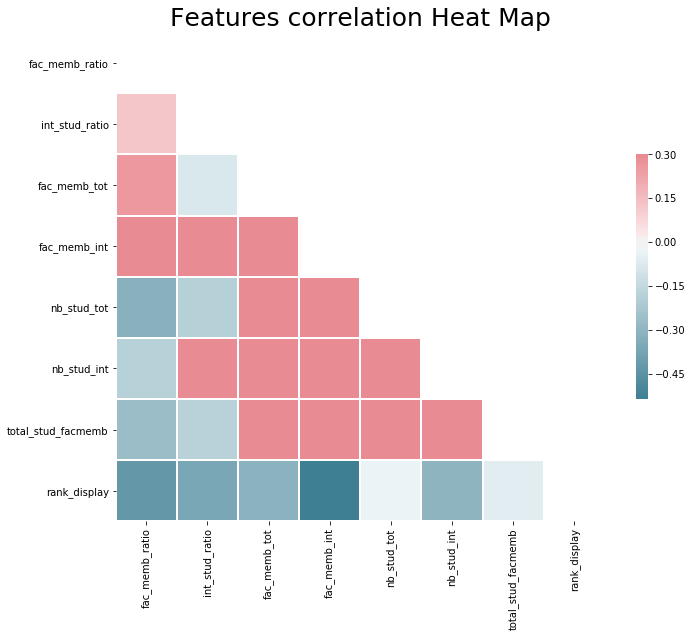

In [13]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5})

plt.title("Features correlation Heat Map", fontsize=25)

In [155]:
# Helper functions
def get_info(data, countries_list_, df, subj_descript):
    
    # GDP in USD
    df = data[data['Subject Descriptor'] \
                       == subj_descript]
    df = df.drop(['Subject Descriptor','Scale', 'Units'],axis=1)
    df.set_index('Country', inplace=True)
    
    # Dataframe cleaning
    columns = [2017, 2022]
    for column in columns:
        df[column] = df[column].replace({r'n/a': ''},regex=True)\
                                                .replace({r',': ''}, regex=True)
    df = df.loc[countries_list_]
    df.fillna(value=-99,axis=1, inplace=True)
    
    for column in columns:
        df[column] = df[column].apply(pd.to_numeric).astype(int)
    
    return df

In [156]:
# Load the data from this new dataset
data = pd.read_excel('WEOApr2017all.xls')
data = data[['Country', 'Subject Descriptor', 'Scale', 'Units', 2017, 2022]]

countries_list_ = qs_df.country.value_counts().index


country_gdp = get_info(data, countries_list_, country_gdp, \
                       'Gross domestic product based on purchasing-power-parity (PPP) per capita GDP')

country_population = get_info(data, countries_list_, country_population, \
                       'Population')

# Rename columns
country_population.rename(columns={2017: 'population_2017', 2022: 'population_2022' }, inplace=True)
country_gdp.rename(columns={2017: 'gdp_2017', 2022: 'gdp_2022' }, inplace=True)

We can observe that the feature with more negative correlation with the rank of the university is the number of international students. In other words, as more international studets has a university, more well placed in the ranking will be.
In the same way, if the faculty members ratio is higher, the university will be better places in the ranking.

Expressed in GDP in PPP dollars per person. Data are derived by dividing GDP in PPP dollars by total population. These data form the basis for the country weights used to generate the World Economic Outlook country group composites for the domestic economy.   The IMF is not a primary source for purchasing power parity (PPP) data. WEO weights have been created from primary sources and are used solely for purposes of generating country group composites. For primary source information, please refer to one of the following sources: the Organization for Economic Cooperation and Development, the World Bank, or the Penn World Tables.  For further information see Box A2 in the April 2004 World Economic Outlook, Box 1.2 in the September 2003 World Economic Outlook for a discussion on the measurement of global growth and Box A.1 in the May 2000 World Economic Outlook for a summary of the revised PPP-based weights, and Annex IV of the May 1993 World Economic Outlook. See also Anne Marie Gulde and Marianne Schulze-Ghattas, Purchasing Power Parity Based Weights for the World Economic Outlook, in Staff Studies for the World Economic Outlook (Washington: IMF, December 1993), pp. 106-23.

The lenght of the qs_df.country.value_counts().index and new_df has been verified

In [157]:
# Set country as a column in gdp df
country_gdp_res = country_gdp.reset_index()
country_gdp_res.rename(columns={'index': 'country'}, inplace=True)

# Set country as a column in population df
country_population_res = country_population.reset_index()
country_population_res.rename(columns={'index': 'country'}, inplace=True)

tot = pd.merge(qs_df, country_gdp_res, how='left', on='country')
tot = pd.merge(tot, country_population_res, how='left', on='country')

In [159]:
tot.gdp_2017.describe()
tot.gdp_2017

#bins = (-110, 0, 42860, 49364, 59609, 90800)
#group_names = ['Unknown', 'Poor', 'Poor-Mid', 'Mid', 'Rich']
#categories = pd.cut(tot.gdp_2017, bins, labels=group_names)
tot.gdp_2017 = categories


In [160]:
tot


,title,rank_display,country,region,fac_memb_tot,fac_memb_int,nb_stud_tot,nb_stud_int,fac_memb_ratio,int_stud_ratio,total_stud_facmemb,gdp_2017,gdp_2022,population_2017,population_2022
0,Massachusetts Institute of Technology (MIT),1,United States,North America,2982,1679,11067,3717,0.269450,0.335863,14049,Mid,70203,325741,338448
1,Stanford University,2,United States,North America,4285,2042,15878,3611,0.269870,0.227422,20163,Mid,70203,325741,338448
2,Harvard University,3,United States,North America,4350,1311,22429,5266,0.193945,0.234785,26779,Mid,70203,325741,338448
3,California Institute of Technology (Caltech),4,United States,North America,953,350,2255,647,0.422616,0.286918,3208,Mid,70203,325741,338448
4,University of Cambridge,5,United Kingdom,Europe,5490,2278,18770,6699,0.292488,0.356899,24260,Poor-Mid,51604,66030,68203
5,University of Oxford,6,United Kingdom,Europe,6750,2964,19720,7353,0.342292,0.372870,26470,Poor-Mid,51604,66030,68203
6,UCL (University College London),7,United Kingdom,Europe,6345,2554,31080,14854,0.204151,0.477928,37425,Poor-Mid,51604,66030,68203
7,Imperial College London,8,United Kingdom,Europe,3930,2071,16090,8746,0.244251,0.543567,20020,Poor-Mid,51604,66030,68203
8,University of Chicago,9,United States,North America,2449,635,13557,3379,0.180645,0.249244,16006,Mid,70203,325741,338448
9,ETH Zurich - Swiss Federal Institute of Techno...,10,Switzerland,Europe,2477,1886,19815,7563,0.125006,0.381681,22292,Rich,69357,8427,8936


In [ ]:
bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager',
                   'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(data.Age, bins, labels=group_names)
    data.Age = categories